# Multi-class classification using gene expression
# Gradient boosted decision trees
[nice primer](https://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html) on trees and boosting

## Required Packages

In [13]:
if (!require(xgboost, quietly=TRUE)) {install.packages('xgboost', repos='http://cran.us.r-project.org')}
if (!require(ggplot2, quietly=TRUE)) {install.packages('ggplot2', repos='http://cran.us.r-project.org')}
if (!require(tidyr, quietly=TRUE)) {install.packages('tidyr', repos='http://cran.us.r-project.org')}
if (!require(Ckmeans.1d.dp, quietly=TRUE)) {install.packages('Ckmeans.1d.dp', repos='http://cran.us.r-project.org')}

## Load data
* big12vxg_vsn = 3041 genes for 23996 voxels of mouse brain, normalized with vsn
* big12factors = 23996 voxels annotated with of coarse neuroanatomical region
* genesAllen = 3041 allen gene names

In [14]:
if (!exists("big12vxg_vsn")) {
    load("/users/rdonovan/shared_data/allen_brain_big12annotation_vsn.Rdata")
}

* X in our gene expression matrix
* y is the brain region each voxel is from

In [41]:
X <- big12vxg_vsn
y <- big12factors
print(dim(X))
print(levels(y))

[1] 23996  3041
 [1] "Cerebellum"              "Cerebral cortex"        
 [3] "Hippocampal region"      "Hypothalamus"           
 [5] "Medulla"                 "Midbrain"               
 [7] "Olfactory areas"         "Pallidum"               
 [9] "Pons"                    "Retrohippocampal region"
[11] "Striatum"                "Thalamus"               


### xgboost doesn't like named labels, so relabel the 12 regions as integers starting at 0

In [17]:
y_int <- y
levels(y_int) <- as.character(1:length(levels(y)) - 1)
y_int <- as.numeric(levels(y_int))[y_int]
N_samples <- length(y_int)

print(dim(X))
print(N_samples)
print(head(colnames(X)))
table(y_int)

[1] 23996  3041
[1] 23996
[1] "Acadl"  "Acadvl" "Accn1"  "Ace"    "Ache"   "Chrna1"


y_int
   0    1    2    3    4    5    6    7    8    9   10   11 
2886 7429 1072  872 1550 1969 2310  489 1161 1002 2170 1086 

### split data into train/test and hold-out sets
* choose model parametres via cross-validation on test/train subset of 75% of data
* evaluate final model on 25% holdout data

In [18]:
p = 0.75
test_train_inds <- sample(1:N_samples, N_samples*p, replace = FALSE)

X_test_train <- X[test_train_inds,]
y_test_train <- y_int[test_train_inds]
X_holdout <- X[-test_train_inds,]
y_holdout <- y_int[-test_train_inds]

## Xgboost parameters

see [here](https://github.com/dmlc/xgboost/blob/master/doc/parameter.md) for info about xgboost parameters.

* **`multi:softmax`** is a multi-class classifier. for some reason you need to set the number of classes manually too.
* **`max_depth`** is the maximium depth each tree can have.  smaller = less overfitting.
* **`eta`** is the learning rate, smaller  = more chance of an optimal model, but slower.

In [19]:
param <- list("objective" = "multi:softmax",
              "num_class" = 12,
              "max.depth" = 3,
              "eta" = 0.1
              )

### cross validation to check parameters give an ok model
* this takes a long time on all the data (abou an hour) so it's commented out for expediency
* ideally you'd play with parameters here to see what gives the best test/train accuracy etc

In [20]:
# gbdt.cv <- xgb.cv(
#     params = param,
#     nfold = 5,
#     data = X_test_train,
#     label = y_test_train,
#     nround = 20,
#     verbose = FALSE,
#     nthread = 16
# )
# tail(gbdt.cv)

## create a single enseble of gradient boosted decision trees with xgboost on all the test/train data

* using 12 cores this takes about 15 minutes, with approximately linear scaling.
* **`nround = 20`** means 20 trees in the ensemble, usually you want more, but speed and a fear of overfitting are both reasons to keep this low.

In [21]:
gbdt <- xgboost(
    params = param,
    data = X_test_train,
    label = y_test_train,
    nround = 20,
    verbose = FALSE,
    nthread = 12
)

### predict the held-out data using the trained model

In [22]:
preds <- predict(gbdt, X_holdout)
fraction_correct <- mean(round(preds) == y_holdout)
fraction_correct

[1] 0.9441574

### grab the most important features

In [23]:
importance_matrix <- xgb.importance(colnames(X),model=gbdt)
print(dim(importance_matrix))
top_genes_info <- head(importance_matrix,50)

[1] 530   4


In [24]:
head(top_genes_info)

,Feature,Gain,Cover,Frequence
1,Satb2,0.105764246962115,0.00836158208369308,0.00238237045860631
2,3110001A13Rik,0.0923344019595857,0.0141740291962022,0.00476474091721263
3,Glra1,0.0697119289528216,0.0519508065370677,0.0262060750446694
4,3110035E14Rik,0.0362456117015873,0.0190564847707098,0.0053603335318642
5,1810041L15Rik,0.0317618696700304,0.0113266799913756,0.00655151876116736
6,Strn,0.0301827504970571,0.00391096964183666,0.00178677784395473


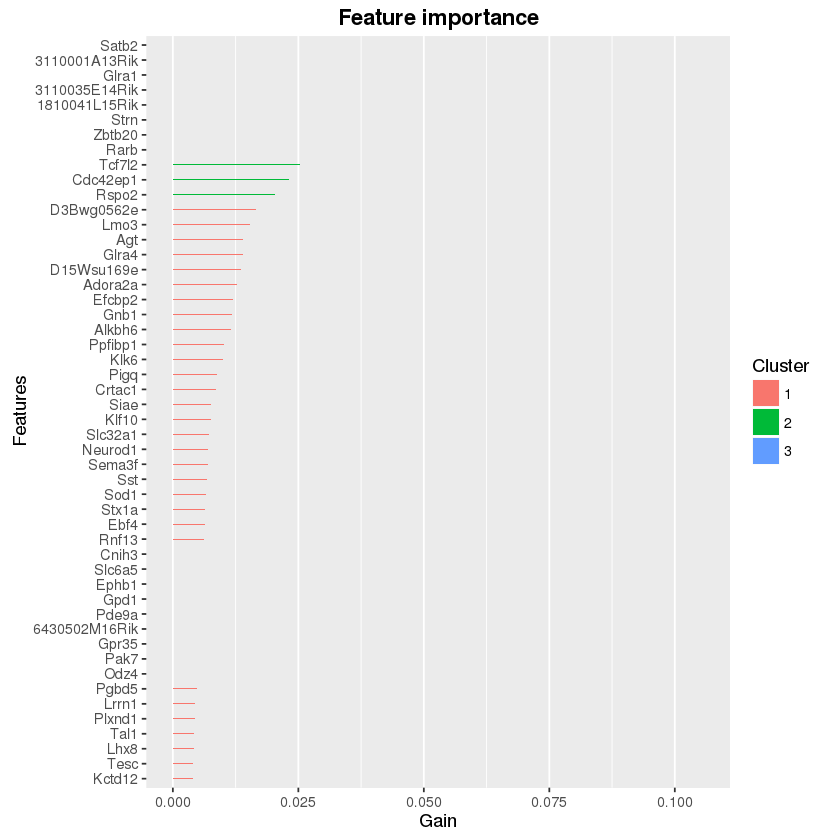

In [25]:
xgb.plot.importance(top_genes_info)

### take a closer look at the top 11 (first two clusters)

In [35]:
top_degs <- (importance_matrix)$Feature[1:11]

### make a tidy dataframe for plotting

In [36]:
deg_df <- cbind(Region=y,data.frame(X[,top_degs]))
deg_df_tidy <- gather(deg_df, 'Gene', 'Expression', -Region)

#### greate a ggplot object with styling

In [31]:
p <- ggplot(deg_df_tidy) + 
    theme_minimal() + 
    theme(legend.position = "bottom")

#### plot gnxp density for the 12 different regions

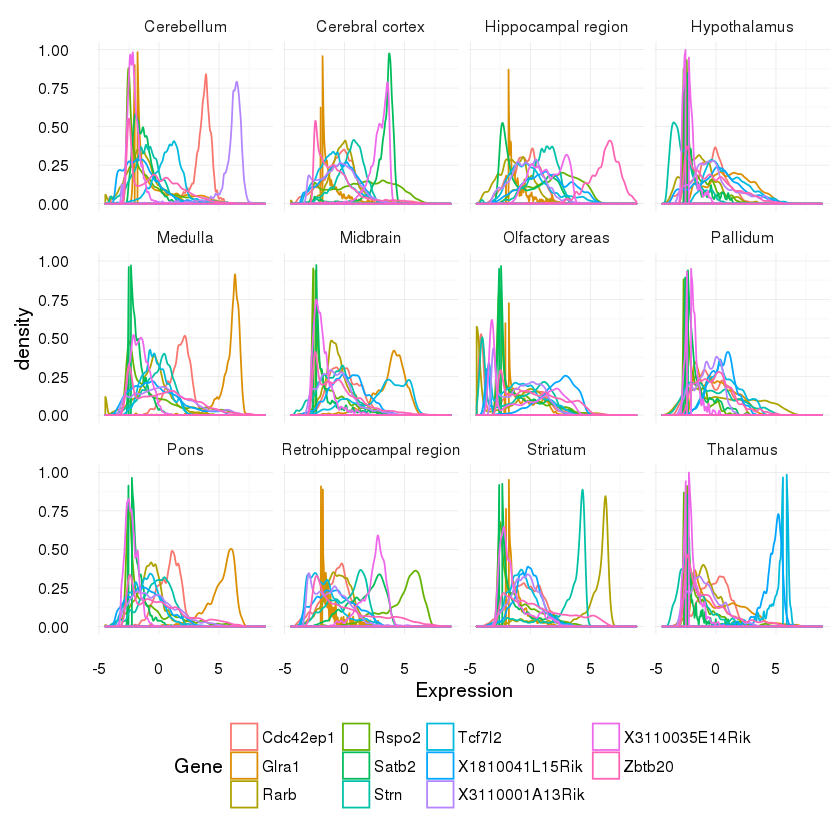

In [38]:
p2 <- p + 
    geom_density(aes(Expression, colour = Gene), adjust = 0.5) + 
    facet_wrap(~ Region) + ylim(0,1)
p2